# Modeling

We will establish a baseline with relatively hands-off machine-learning classifiers before using a more easily interpretable model.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pickle

hmda = pd.read_parquet("processed_data.pqt")
with open("concordance.pkl", "rb") as f:
    concordances = pickle.load(f)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Transformations

We may want to add additional factors later, but for now we definitely want to transform income and hud_median_income to ratios, of the loan amount and of income, respectively.

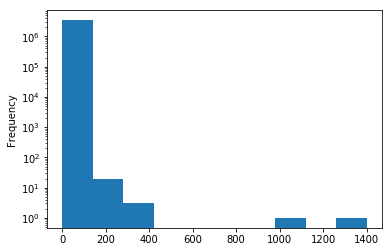

In [3]:
hmda.loc[:, 'income_to_loan'] = hmda['applicant_income_000s'].div(hmda['loan_amount_000s'])
hmda.loc[:, 'income_to_med_income'] = hmda['loan_amount_000s'].mul(1000).div(hmda['hud_median_family_income'])
hmda.loc[:, 'income_to_loan'].dropna().plot(kind='hist', logy=True)

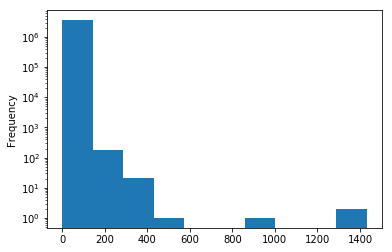

In [4]:
hmda.loc[:, 'income_to_med_income'].dropna().plot(kind='hist', logy=True)

All of the action we care about is in the ratio < 1, I expect.

## Testing and Training samples.

In [5]:
from sklearn.model_selection import train_test_split
hmda_train, hmda_test = train_test_split(hmda.dropna(), test_size=0.99) #high proportion of test data to speed up modeling
hmda_train.shape

(31743, 33)

## SVM

We need to convert the continuous or high-category data into a few factors, but otherwise we should be able to run a support vector machine without much trouble. I'm going to try a linear kernel on normalized data. With a linear kernel, we can look at coefficients to determine what was important to the fit.

In [17]:
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, Binarizer, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC

In [35]:
mapper = DataFrameMapper([
    (['population'], KBinsDiscretizer(n_bins=3)),
    (['applicant_income_000s'], KBinsDiscretizer(n_bins=5)),
    (['loan_amount_000s'], Binarizer(threshold=700)), # > ~700 are non-conforming loans for FHA
    (['minority_population'], KBinsDiscretizer(n_bins=3)),
    (['income_to_loan'], KBinsDiscretizer(n_bins=5)),
    (['income_to_med_income'], KBinsDiscretizer(n_bins=3)),
    (['applicant_ethnicity'], OneHotEncoder()),
    (['applicant_race_1'], OneHotEncoder()),
    (['applicant_sex'], OneHotEncoder()),
    (['as_of_year'], OneHotEncoder()),
    (['loan_purpose'], OneHotEncoder())
     ])
pipe = make_pipeline(mapper, StandardScaler(), SVC(kernel='linear', class_weight='balanced')) #class_weight is set to fix the unbalanced outcomes vector (many more approvals than rejections)
pipe.fit(hmda_train, hmda_train.approved.astype("float"))

/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "catego

Pipeline(memory=None,
     steps=[('dataframemapper', DataFrameMapper(default=False, df_out=False,
        features=[(['population'], KBinsDiscretizer(encode='onehot', n_bins=3, strategy='quantile')), (['applicant_income_000s'], KBinsDiscretizer(encode='onehot', n_bins=5, strategy='quantile')), (['loan_amount_000s'], Binarize...r', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [116]:
concordances['applicant_race_1'][7] = "NA"

In [155]:
coef_names = []
for (nm, transformer) in pipe.named_steps['dataframemapper'].features:
    if isinstance(transformer, KBinsDiscretizer):
        coef_names.extend([f"{nm[0]}_{v}" for v in transformer.bin_edges_[0][:-1]])
    elif isinstance(transformer, Binarizer):
        coef_names.extend([f"{nm[0]}"])
    elif isinstance(transformer, OneHotEncoder):
        if nm[0] in concordances:
            coef_names.extend(["{}_{}".format(nm[0],concordances[nm[0]][int(v[3])]) for v in transformer.get_feature_names()])
        else:
            coef_names.extend(transformer.get_feature_names())

In [156]:
pd.DataFrame({'names':coef_names, 'coefficient':pipe.named_steps['svc'].coef_.ravel()}).sort_values('coefficient').round(5)

,names,coefficient
47,loan_purpose_Refinancing,-0.46014
46,loan_purpose_Home improvement,-0.18000
28,applicant_race_1_White,-0.00031
29,applicant_race_1_Information not provided by a...,-0.00024
26,applicant_race_1_Black or African American,-0.00019
25,applicant_race_1_Asian,-0.00017
24,applicant_race_1_American Indian or Alaska Native,-0.00004
27,applicant_race_1_Native Hawaiian or Other Paci...,-0.00004
3,applicant_income_000s_1.0,-0.00003
12,income_to_loan_0.0024390243902439024,-0.00003


* Very few coefficients were significant. This is not a good fit.
* Loan purpose turned up as inordinately important, with home purchases being much more likely to be approved. 
* Non-conforming (>\$700k) loans actually were more likely to be approved.
* Race and ethnicity show up as some of the most important factors, but the pattern is not what might be expected. Hispanics were more likely to be approved, and Whites were significantly less likely. This is a big surprise.

In [45]:
from sklearn.metrics import confusion_matrix
svm_hat = pipe.predict(hmda_test.iloc[:100000,:])
confusion_matrix(hmda_test.approved.astype("float").iloc[:100000], svm_hat)

array([[19488,  7616],
       [36713, 36183]])

Not a particularly effective fit, with as many false negatives as true positives. It looks as though the SVM wasn't able to handle the unbalanced outcome.

### PCA (Again)

Having done all that work on proper encoding of features, let's just check if a Principal Components Analysis is more effective now.

In [144]:
from sklearn.decomposition import PCA
pca_pipe = make_pipeline(mapper, StandardScaler(), PCA(n_components=5)) 
pca_pipe.fit(hmda_train)
pca = pca_pipe.named_steps['pca']
print(pca.explained_variance_ratio_)

/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can 

[0.17828983 0.11431848 0.10865586 0.09033409 0.07278618]


A bit better than before.

/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


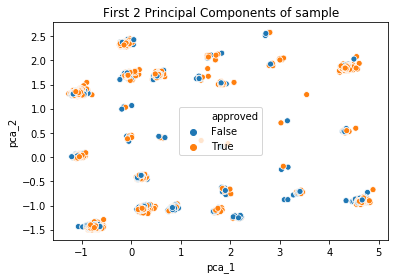

In [150]:
pca_hat = pd.DataFrame(pca_pipe.transform(hmda_train)[:5000,:2], columns=['pca_1', 'pca_2'])
pca_hat.loc[:, 'approved'] =  hmda_train.iloc[:5000,:].approved.values
ax = sns.scatterplot(x='pca_1', y='pca_2', hue='approved', data=pca_hat)
ax.set_title("First 2 Principal Components of sample")
plt.show()

That's what we get for using discretized data everywhere.

## Logit Regression

We'll try only one other model as we have time constraints: a traditional logistic regression, with parameter choice informed by the SVM above.

We'll use more continuous factors this time, although the extreme right skew in income and associated factors means we should either censor the data or, my preference, do a log transform on it.

In [48]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
Log = FunctionTransformer(np.log)
Log1p = FunctionTransformer(np.log1p)
mapper = DataFrameMapper([
    (['population'], Log),
    (['applicant_income_000s'], Log),
    (['minority_population'], Binarizer(threshold=0.5)), #we know from graphing the data that there are relatively few mixed neighborhoods
    (['income_to_loan'], Log1p), #We'll add one to these ratios as I suspect the threshold for denying a loan is somewhere down close to 0, nowhere near 1.
    (['income_to_med_income'], Log1p),
    (['applicant_ethnicity'], OneHotEncoder()),
    (['applicant_race_1'], OneHotEncoder()),
    (['loan_purpose'], OneHotEncoder())
     ])
pipe_logit = make_pipeline(mapper, LogisticRegression(solver="sag")) #the SAG solver is supposed to be faster for large datasets. I believe the factors are approximately scaled as-is.
pipe_logit.fit(hmda_train, hmda_train.approved)

/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-pack

Pipeline(memory=None,
     steps=[('dataframemapper', DataFrameMapper(default=False, df_out=False,
        features=[(['population'], FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<ufunc 'log'>, inv_kw_args=None, inverse_func=None,
          kw_args=None, pass_y='deprecated', validate=None)), (['... penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False))])

In [153]:
coef_names = []
for (nm, transformer) in pipe_logit.named_steps['dataframemapper'].features:
    if isinstance(transformer, (FunctionTransformer, Binarizer)):
        coef_names.extend([f"{nm[0]}"])
    elif isinstance(transformer, OneHotEncoder):
        if nm[0] in concordances:
            coef_names.extend(["{}_{}".format(nm[0],concordances[nm[0]][int(v[3])]) for v in transformer.get_feature_names()])
        else:
            coef_names.extend(transformer.get_feature_names())

In [154]:
pd.DataFrame({'names':coef_names, 'coefficient':pipe_logit.named_steps['logisticregression'].coef_.ravel()}).sort_values('coefficient').round(2)

,names,coefficient
4,income_to_med_income,-1.27
3,income_to_loan,-1.06
17,loan_purpose_Home improvement,-0.52
18,loan_purpose_Refinancing,-0.50
11,applicant_race_1_Black or African American,-0.46
5,applicant_ethnicity_Hispanic or Latino,-0.46
9,applicant_race_1_American Indian or Alaska Native,-0.45
12,applicant_race_1_Native Hawaiian or Other Paci...,-0.27
7,applicant_ethnicity_Information not provided b...,-0.18
14,applicant_race_1_Information not provided by a...,-0.11


In [51]:
pipe_logit.named_steps['logisticregression'].intercept_

array([-2.00460545])

I'm surprised we wound up with a negative intercept, given that approvals are more common than rejections. Several of the coefficients look intuitively wrong, too. The Income_to_loan and income to median income ratios, for example, both have significant negative effects. There may be too much collinearity between the three income-related features. Race and Ethnicity, on the other hand, are now more or less what I would expect.

Let's check the confusion matrix for this one.

In [53]:
logit_hat = pipe_logit.predict(hmda_test.iloc[:100000,:])
confusion_matrix(hmda_test.approved.astype("float").iloc[:100000], logit_hat)

/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


array([[ 4091, 23013],
       [ 2729, 70167]])

That's better, but now we are erring on the side of false positives.

Let's simplify the features we're examining to see if it makes much difference.

In [66]:
mapper = DataFrameMapper([
    (['population'], Log),
    (['applicant_income_000s'], Log),
    (['minority_population'], Binarizer(threshold=0.5)), #we know from graphing the data that there are relatively few mixed neighborhoods
    (['applicant_ethnicity'], OneHotEncoder()),
    (['applicant_race_1'], OneHotEncoder()),
    (['loan_purpose'], OneHotEncoder())
     ])
pipe_logit2 = make_pipeline(mapper, LogisticRegression(solver="sag")) #the SAG solver is supposed to be faster for large datasets. I believe the factors are approximately scaled as-is.
pipe_logit2.fit(hmda_train, hmda_train.approved)

/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can 

Pipeline(memory=None,
     steps=[('dataframemapper', DataFrameMapper(default=False, df_out=False,
        features=[(['population'], FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<ufunc 'log'>, inv_kw_args=None, inverse_func=None,
          kw_args=None, pass_y='deprecated', validate=None)), (['... penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False))])

In [151]:
coef_names = []
for (nm, transformer) in pipe_logit2.named_steps['dataframemapper'].features:
    if isinstance(transformer, (FunctionTransformer, Binarizer)):
        coef_names.extend([f"{nm[0]}"])
    elif isinstance(transformer, OneHotEncoder):
        if nm[0] in concordances:
            coef_names.extend(["{}_{}".format(nm[0],concordances[nm[0]][int(v[3])]) for v in transformer.get_feature_names()])
        else:
            coef_names.extend(transformer.get_feature_names())
pd.DataFrame({'names':coef_names, 'coefficient':pipe_logit2.named_steps['logisticregression'].coef_.ravel()}).sort_values('coefficient').round(2)

,names,coefficient
9,applicant_race_1_Black or African American,-0.52
3,applicant_ethnicity_Hispanic or Latino,-0.51
16,loan_purpose_Refinancing,-0.47
15,loan_purpose_Home improvement,-0.44
7,applicant_race_1_American Indian or Alaska Native,-0.41
10,applicant_race_1_Native Hawaiian or Other Paci...,-0.28
5,applicant_ethnicity_Information not provided b...,-0.16
8,applicant_race_1_Asian,-0.12
12,applicant_race_1_Information not provided by a...,-0.07
2,minority_population,0.01


In [143]:
logit_hat = pipe_logit2.predict(hmda_test.iloc[:100000,:])
confusion_matrix(hmda_test.approved.astype("float").iloc[:100000], logit_hat)

/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


array([[ 2449, 24655],
       [ 1830, 71066]])

The simpler model is not much less accurate.

# Conclusions

In the final model, we have extracted some basic features for loan approval, mostly squaring with our prior assumptions:

* **White, non-Hispanic** applicants were approved more frequently than other races. 
* **Home purchase** loans are more likely to be approved than Home improvement or refinancing loans, both of which are taking equity out of a house, and hence inherently more risky. 
* **Wealthier** applicants were more likely to get their loans approved. 

We also had some surprises: 

* Being **Asian had a negative impact** on mortgage approval. One might guess that Asian applicants' numbers were skewed by foreign purchases of NY real estate, but further study is needed.
* The ratio of the applicant's **income to the size of the loan was not relevant**.  The income-to-loan ratio's irrelevance might be due to survival bias; we filtered out incomplete applications, and possibly those applicants with a large imbalance in loan to income and no other mitigating factors didn't get far enough in the process to show up in the data.


There is a great deal more work to be done here. If we could find additional data on these loans, probably the single most important feature currently missing would be the percent down payment being made on each mortgage. The spread of the proposed interest rate over some average would also be informative.

It might also make sense to concentrate in commonalities in loan rejections, as they are less frequent. We could flip the encoding of loan approval to be loan rejection, then fit a zero-inflated poisson model.

We could also use the census tract data to break the applications into regions of NY State, then fit a hierarchical model permitting some different effects depending on region. That would take some work to determine how to aggregate the census tracts, however, as a model with one group for each would be ungainly.